In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots  import figsizes

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [2]:
from analysis import sweep2df, format_violin

In [3]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [128]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

In [136]:
"""Moebius gamma ablation"""
SWEEP_ID = "2y77igd1"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"moebius_sweep_{SWEEP_ID}.csv"
print(f"Loading sweep with {SWEEP_ID=}")
moebius_df = sweep2df(sweep.runs, filename, save=True, load=True)

moebius_df = moebius_df[moebius_df.gamma_square <= 1e5]

"""Moebius + linear map (20 seeds)"""
SWEEP_ID = "vtyztyfn"
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
print(f"Loading sweep with {SWEEP_ID=}")
filename = f"moebius_lin_map_sweep_{SWEEP_ID}.csv"
runs_df1 = sweep2df(sweep.runs, filename, save=True,load=True)

"""Moebius + linear map (80 seeds)"""
SWEEP_ID = "uac6296c"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"moebius_lin_map_sweep_{SWEEP_ID}.csv"
print(f"Loading sweep with {SWEEP_ID=}")
runs_df2 = sweep2df(sweep.runs, filename, save=True,load=True)

moebius_lin_map_df = pd.concat([runs_df1, runs_df2]).reset_index(drop=True)

"""AR flow (100 seeds)"""
SWEEP_ID = "afkhqbu9"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"ar_flow_sweep_{SWEEP_ID}.csv"
print(f"Loading sweep with {SWEEP_ID=}")
flow_df = sweep2df(sweep.runs, filename, save=True, load=False)

Encountered a faulty run with ID worthy-sweep-103
Encountered a faulty run with ID jumping-sweep-103
Encountered a faulty run with ID laced-sweep-101
Encountered a faulty run with ID hopeful-sweep-100
Encountered a faulty run with ID magic-sweep-99
Encountered a faulty run with ID vivid-sweep-98
Encountered a faulty run with ID royal-sweep-97
Encountered a faulty run with ID breezy-sweep-96
Encountered a faulty run with ID zany-sweep-95
Encountered a faulty run with ID grateful-sweep-94
Encountered a faulty run with ID crisp-sweep-93
Encountered a faulty run with ID dauntless-sweep-92
Encountered a faulty run with ID helpful-sweep-91
Encountered a faulty run with ID ethereal-sweep-90
Encountered a faulty run with ID polar-sweep-89
Encountered a faulty run with ID major-sweep-88
Encountered a faulty run with ID clean-sweep-87
Encountered a faulty run with ID hopeful-sweep-86
Encountered a faulty run with ID revived-sweep-85
Encountered a faulty run with ID atomic-sweep-84
Encountered a 

## Data inspection

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

### Moebius $\gamma$ ablation

In [147]:
moebius_df[["cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
10.0                      20.0  1.335482  0.564094  0.611589  0.792626   
100.0                     20.0  1.236132  0.559228  0.450587  0.768593   
1000.0                    19.0  0.068911  0.139163  0.002055  0.002738   
10000.0                   18.0  0.001694  0.001008  0.000548  0.000933   
100000.0                  20.0  0.004486  0.003369  0.000571  0.002154   

                                            
                   50%       75%       max  
gamma_square                                
10.0          1.350295  1.737893  2.397702  
100.0         1.049250  1.718161  2.334175  
1000.0        0.004156  0.007729  0.444581  
10000.0       0.001556  0.002046  0.003893  
100000.0      0.003660  0.005736  0.012824

In [148]:
moebius_df[["mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
10.0                     20.0  0.152054  0.002594  0.145711  0.150620   
100.0                    20.0  0.150781  0.003009  0.144056  0.149297   
1000.0                   19.0  0.711884  0.095085  0.529063  0.738003   
10000.0                  18.0  0.960569  0.008208  0.945257  0.954324   
100000.0                 20.0  0.960279  0.008393  0.945410  0.954748   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.151827  0.153587  0.156768  
100.0         0.150826  0.152549  0.156737  
1000.0        0.758195  0.764575  0.773091  
10000.0       0.960455  0.967798  0.972966  
100000.0      0.960646  0.965914  0.977027

In [149]:
moebius_df[["min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

min_neg_elbo                                                    \
                    count      mean       std       min       25%       50%   
gamma_square                                                                  
10.0                 20.0 -0.631330  0.001146 -0.633572 -0.632227 -0.631218   
100.0                20.0 -3.733695  0.001176 -3.736262 -3.734592 -3.733493   
1000.0               19.0 -4.696911  0.014440 -4.711015 -4.707474 -4.705772   
10000.0              18.0 -4.745679  0.116238 -4.889962 -4.827169 -4.769033   
100000.0             20.0 -3.961198  0.287607 -4.266053 -4.183210 -4.077030   

                                  
                   75%       max  
gamma_square                      
10.0         -0.630326 -0.629624  
100.0        -3.732953 -3.731812  
1000.0       -4.687442 -4.660370  
10000.0      -4.670219 -4.476871  
100000.0     -3.825058 -3.312922

### Moebius + linear map and AR Flows

(<AxesSubplot:>, <AxesSubplot:>)

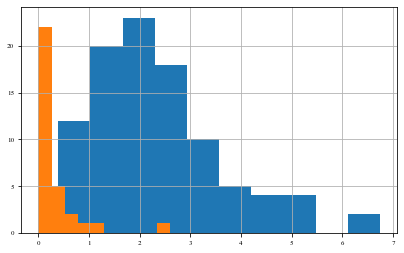

In [150]:
moebius_lin_map_df.mixing_linear_map_cima.hist(), flow_df.mixing_cima.hist()

# Data pre-porcessing

## Moebius $\gamma$ ablation

In [151]:
# if we need to filter outliers, use this
# "max" means no filtering is done
elbo_filter = moebius_df[["neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['max']
groups = [g for _, g in moebius_df[["neg_elbo", "mcc4min_neg_elbo", "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square")]

# filter metrics based on ELBO threshold (if applicabble)
gg_mcc = [g[g.neg_elbo <= threshold].mcc4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

## Moebius + linear map and AR Flows

In [152]:
"""Data for Mobius with linear maps"""
# get quartiles
quartile_bins = moebius_lin_map_df.mixing_linear_map_cima.describe()[["min", "25%", "50%", "75%", "max"]].tolist()

NUM_BINS = 6 #len(quartile_bins)

# create a log set of bins
bins = np.logspace( np.log10(moebius_lin_map_df.mixing_linear_map_cima.min()-1e-8), np.log10(moebius_lin_map_df.mixing_linear_map_cima.max()+1e-8), NUM_BINS)
logbins = sorted(np.log10(bins))
binned_cima = pd.cut(moebius_lin_map_df.mixing_linear_map_cima, bins=bins, labels=list(range(NUM_BINS-1)), retbins=False, right=True, include_lowest=True)
moebius_lin_map_groups = [moebius_lin_map_df.mcc4min_neg_elbo[binned_cima==label] for label in list(range(NUM_BINS-1))]

# Plot

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_25805/746548530.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + sorted(np.log10(moebius_df["gamma_square"]).astype(int).unique()))
/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_25805/746548530.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( xticklabels)


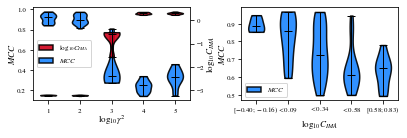

In [177]:
LABELPAD = 0
TICK_PADDING = 2

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2)['figure.figsize'])


"""MCC vs CIMA over different gamma"""
ax = fig.add_subplot(121)

# create double y-axis
ax2 = ax.twinx()

# MCC
vp= ax.violinplot(gg_mcc, showmedians=True)
format_violin(vp,'#D0021B')

# CIMA
vp2= ax2.violinplot([np.log10(g) for g in gg_cima], showmedians=True)
format_violin(vp2)

# set z-order to make CIMA the top plot
# https://stackoverflow.com/a/30506077/16912032
ax.set_zorder(ax.get_zorder()+1)
ax.set_frame_on(False)

ax2.set_ylabel("$\log_{10} C_{IMA}$", labelpad=LABELPAD)
ax.set_ylabel("$MCC$", labelpad=LABELPAD)

ax.set_xlabel("$\log_{10}\gamma^2$", labelpad=LABELPAD)
ax.set_xticklabels([0] + sorted(np.log10(moebius_df["gamma_square"]).astype(int).unique()))
plt.legend([vp['bodies'][0],vp2['bodies'][0]], ["$\log_{10} C_{IMA}$", "$MCC$"], loc='center left')


"""MCC vs the mixing lin map's CIMA"""
ax = fig.add_subplot(122)
vp = plt.violinplot(moebius_lin_map_groups, showmedians=True)
format_violin(vp)

ax.set_ylabel("$MCC$", labelpad=LABELPAD)
ax.set_xlabel("$\log_{10}C_{IMA}$", labelpad=LABELPAD+3)

xticklabels = [0]+ [f"$[{logbins[0]:.2f};{logbins[1]:.2f})$"]+ [f"$<{logbins[i]:.2f}$" for i in range(2,NUM_BINS-1)] +[f"$[{logbins[-2]:.2f};{logbins[-1]:.2f})$"]
ax.set_xticklabels( xticklabels)
# plt.legend()
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)
plt.legend([vp['bodies'][0],], ["$MCC$"], loc='lower left')

plt.savefig("moebius_mcc_cima.svg")

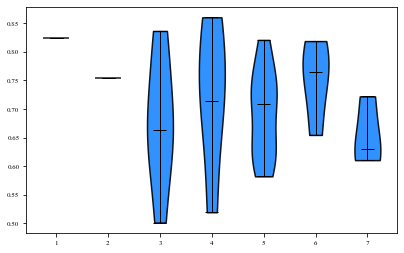

In [178]:
quartile_bins = flow_df.mixing_cima.describe()[["min", "25%", "50%", "75%", "max"]].tolist()
NUM_BINS = 8#len(quartile_bins)
bins = np.logspace( np.log10(flow_df.mixing_cima.min()-1e-8), np.log10(flow_df.mixing_cima.max()+1e-8), NUM_BINS)
binned_cima = pd.cut(flow_df.mixing_cima, bins=bins, labels=list(range(NUM_BINS-1)), retbins=False, right=True, include_lowest=True)

groups = [flow_df.mcc4min_neg_elbo[binned_cima==label] for label in list(range(NUM_BINS-1))]
vp = plt.violinplot(groups, showmedians=True)
format_violin(vp)